In [1]:
import subprocess
import os
import numpy as np
import shutil
import signal
import sys
from datetime import datetime

from collections import deque, namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

In [2]:
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    
def load_model(model, filepath):
    model.load_state_dict(torch.load(filepath))
    model.eval()

SMALL_NUMBER=float('-inf')
INPUT_DIM=3
HIDDEN_DIM=16
OUTPUT_DIM=2
class DQN(nn.Module):
    def __init__(self, INPUT_DIM, HIDDEN_DIM,OUTPUT_DIM):
        super(DQN, self).__init__()
        self.input = nn.Linear(INPUT_DIM, HIDDEN_DIM)
        self.fc1 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        self.fc2 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        self.fc3 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        # self.fc4 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        # self.fc5 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        # self.fc6 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        # self.fc7 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        # self.fc8 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        # self.fc9 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        self.move_piece = nn.Linear(HIDDEN_DIM, OUTPUT_DIM)

        A=0.1
        self.dropout = nn.Dropout(A)
        self.dropout1 = nn.Dropout(A)
        self.dropout2 = nn.Dropout(A)




    
    def forward(self, y, mask,valid_moves_tensor):
    
       
        x = torch.relu(self.input(y))
        x = torch.relu(self.fc1(x))
        # x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        # x = self.dropout1(x)
        x = torch.relu(self.fc3(x))
        # x = self.dropout2(x)
        # x = torch.relu(self.fc4(x))
        # x = torch.relu(self.fc5(x))
        # x = torch.relu(self.fc6(x))
        # x = torch.relu(self.fc7(x))
        # x = torch.relu(self.fc8(x))
        # x = torch.relu(self.fc9(x))
        

        move_piece = self.move_piece(x)

        if mask:
            # mask_tensor = torch.full_like(move_piece, 0)
            mask_tensor = torch.full_like(move_piece, SMALL_NUMBER)
            mask_tensor[valid_moves_tensor.bool()] = 0

            move_piece += mask_tensor
        return move_piece

In [3]:
# Example agent that changes parameters based on stats
def dton(state):
    return np.array(list(state.values()))
def convert(state):
    return torch.FloatTensor(state.flatten()).unsqueeze(0)

def move_nn_to_adjustments(move_nn, state):

    current_acBECwminLink1=state['acBECwminLink1']
    current_acBECwStageLink1=state['acBECwStageLink1']

    if move_nn == 0:
        current_acBECwminLink1 -=1
    elif move_nn == 1:
        current_acBECwminLink1 += 1

    adjustments= {
        'acBECwminLink1' : current_acBECwminLink1,
        'acBECwStageLink1': current_acBECwStageLink1,
    }

    return adjustments

class SimpleAgent:
    def __init__(self, filepath):
        self.dqn=DQN(INPUT_DIM, HIDDEN_DIM,OUTPUT_DIM)
        self.dqn.load_state_dict(torch.load(filepath))
        self.type = 'DQN'

    def decide(self, state, valid_moves):

        self.dqn.eval()
        state_c=convert(dton(state))
        valid_moves_c=convert(valid_moves)
        with torch.no_grad():
            # move_piece_q  = self.dqn(state,True,convert(self.game.vector_valid_moves(self.unique_id)))
            move_piece_q  = self.dqn(state_c,True)
            num_moves_choices=1
            move_nn=torch.argsort(move_piece_q[0], descending=True)[np.random.choice(num_moves_choices)].item()

            return move_nn
        


class Environnment:
    def __init__(self,step_size=10,max_steps=10):
        self.step_size=max(step_size,1.1)
        self.max_steps=max_steps

        self.directory = "users/barbarianmatt/code/python/ee595projectai/ns-3-dev"

        self.reset()

    def reset(self):
        start=np.random.choice(50)+3
        self.state={
            'acBECwminLink1': start,
            'acBECwStageLink1': 6,

            'mldThptTotal': 0.001,
        }

        self.parameters={
            'simulationTime': self.step_size,
            'acBECwminLink1': start,
            'acBECwStageLink1': 6,
            'mldPerNodeLambda' : 0.01,
            'rngRun': np.random.choice(10000),
        }

        self.num_steps=0


        # self.step()

        return self.get_state()


    def step(self):

        
        # cmd = 'single-bss-mld'
        # for key in self.parameters:
        #     val = self.parameters[key]
        #     cmd+= f' --{key}={val}'

        # command = f"cd /mnt/c/{self.directory} && ./ns3 run '{cmd}'"


        # process = subprocess.Popen(
        #     ["wsl", "-e", "bash", "-c", command],
        #     stdout=subprocess.PIPE,
        #     stderr=subprocess.PIPE,
        #     text=True
        # )

        # try:
        #     for line in process.stdout:
        #         print(line, end="")  
        #     for line in process.stderr:
        #         print(line, end="")
        # finally:
        #     print('done')

        # self.update_state()

        self.parameters['rngRun']+=1

        self.state['acBECwminLink1']=self.parameters['acBECwminLink1']

        if self.state['acBECwminLink1']>32:
            self.state['mldThptTotal'] = self.state['acBECwminLink1'] * -3
        elif self.state['acBECwminLink1']<=32:
            self.state['mldThptTotal'] = self.state['acBECwminLink1'] * 3
    

        self.num_steps +=1


    def update_state(self):
        # print(self.state)
        with open('C:/'+self.directory+'/wifi-mld.dat', 'r') as f:
            lines = f.readlines()

            df = lines[-1].split(',')
            
            ac_be_cwmin_link1 = int(df[33])
            ac_be_cwstage_link1 = int(df[34])

            mld_thpt_total = float(df[5])

            # print('num: ',ac_be_cwmin_link1, df[33])
            
            self.state['acBECwminLink1']=ac_be_cwmin_link1+1
            self.state['acBECwStageLink1']=ac_be_cwstage_link1
            self.state['mldThptTotal']=mld_thpt_total
        
        # print('state: ',self.state)
        

    
    def get_state(self):
        return self.state
    
    def update_environment(self, move_nn):

        action = move_nn_to_adjustments(move_nn, self.get_state())

        # print('action: ', action)

        for key in action:
            adjustment = action[key]
            self.parameters[key]=adjustment
        
        self.step()

        reward = self.calc_reward()

        
        done = self.num_steps>self.max_steps

        return self.get_state(), reward, done



    def calc_reward(self):
        reward = self.state['mldThptTotal']/10
        return reward

    def get_valid_moves(self):
        valid_moves = np.array([1,1])

        if self.state['acBECwminLink1']<=2:
            valid_moves[0]=0
        
        if self.state['acBECwminLink1']>=64:
            valid_moves[1]=0
        
        return valid_moves


In [4]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
        self.size=len(self.buffer)
    def push(self, *args):
        self.buffer.append(args)
        self.size=len(self.buffer)
    # random sampling
    def sample(self, batch_size):
        batch_size = min(batch_size, len(self.buffer))
        indices = np.random.choice(len(self.buffer), size=batch_size, replace=False)
        samples=[self.buffer[i] for i in indices]
        self.buffer = deque([self.buffer[i] for i in range(len(self.buffer)) if i not in indices], maxlen=self.capacity)
        # samples = [self.buffer.popleft() for _ in range(batch_size)]
        self.size=len(self.buffer)
        return samples

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done', 'valid_moves', 'next_valid_moves'))

def train_dqn(env, dqn, target_dqn, episodes=1000, batch_size=64, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01,lr_start=1e-4, lr_end=1e-4, eval_every=100, games_per_eval=100):
    episodes=int(episodes)
    optimizer = optim.Adam(dqn.parameters(), lr_start)
    loss_fn = nn.MSELoss()
    lr_decay= (lr_end / lr_start) ** (1 / episodes)
    scheduler = StepLR(optimizer, step_size=1, gamma=lr_decay)

    epsilon = epsilon_start
    epsilon_decay = (epsilon_end / epsilon_start) ** (1 / (0.9*episodes))
    optimizer.optimizations=0
    optimizer.optimizations_cyclic=0

    replay_buffer=ReplayBuffer(3*batch_size)

    total_rewards_list=[]

    # filepath='./dqn_new_model.pth'
    # load_model(dqn, filepath)
    # load_model(target_dqn, filepath)

    print("correct one good job")
    def optimize_model(replay_buffer, model, target_model,optimizer):
        total_loss=0
        model.train()
        while replay_buffer.size >= batch_size:
            optimizer.optimizations+=1
            optimizer.optimizations_cyclic+=batch_size
            transitions = replay_buffer.sample(batch_size) # state, move, reward, resulting_state, done, repeat
            batch = Transition(*zip(*transitions)) # seperates into a more usable structure

            # print('batch: ',batch)
            # print(batch.action)

            # seperate batch into variables
            state_batch = torch.cat(batch.state)
            action_batch = torch.tensor(batch.action, dtype=torch.int64) #change to int8
            reward_batch = torch.tensor(batch.reward, dtype=torch.float32)
            next_state_batch = torch.cat(batch.next_state)
            done_batch = torch.tensor(batch.done, dtype=torch.float32)
            valid_moves_batch = torch.cat(batch.valid_moves)
            next_valid_moves_batch = torch.cat(batch.next_valid_moves)
            # print(next_state_batch[0])
            # print(next_state_batch[1])
            # print()
            

            q_values = model(state_batch,True, valid_moves_batch) # the models responses to different states, masked for legality
            state_action_values = q_values.gather(1, action_batch.view(-1, 1)).squeeze() # q_values of the actions it actually took

            next_q_values = model(next_state_batch, True,next_valid_moves_batch) # the models responses to the resulting states as the next player
            next_actions = next_q_values.max(1)[1] # what that player likely would have done
            next_target_q_values = target_model(next_state_batch, True,next_valid_moves_batch) # target model which is updated less frequently for stability
            next_state_values = next_target_q_values.gather(1, next_actions.unsqueeze(1)).squeeze() # q_values of the other player likely to result from your actions
            
            # print('reward batch: ',reward_batch)
            # print('action batch: ',action_batch.view(-1, 1))
            # print('next_actions: ',next_actions)
            # print('state batch: ',state_batch)
            # print('next state batch: ',next_state_batch)
            # print('state_action_values: ',state_action_values)
            # print('q_values',q_values)
            # print('next_target_q_values',next_target_q_values)
            # print('next_state_values',next_state_values)
            # print('done batch',done_batch)
            # print('valid_moves batch',valid_moves_batch)
            # print('newt_valid_moves batch',next_valid_moves_batch)

            expected_state_action_values = reward_batch + gamma * (next_state_values * (1 - done_batch)) # what the reward is from your actions

            # print(expected_state_action_values)
            
            base_loss =loss_fn(state_action_values, expected_state_action_values)

            # wild_jack_mask = (action_batch >= 96) & (action_batch < 192)  # Identify wild jack moves
            # proper_use_mask = reward_batch > 0  # Identify moves that resulted in a positive reward

            # # If the wild jack was used but no positive reward was obtained, increase the loss
            # wild_jack_loss_weight = torch.ones_like(base_loss)  # Initialize loss weights to 1 (no change)
            # wild_jack_loss_weight[wild_jack_mask & ~proper_use_mask] = 1.5  # Increase loss for wasted wild jacks
            # wild_jack_loss_weight[wild_jack_mask & proper_use_mask] = 0.8   # Decrease loss for good use of wild jacks

            # # Apply weighted loss
            # loss = base_loss * wild_jack_loss_weight
            loss= base_loss

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 10.0)
            optimizer.step()
            total_loss+=loss.item()
        
        return total_loss
    
    def select_epsilon_greedy_action(env, model, state, epsilon, valid_moves):
        rand=np.random.rand()
        if rand<epsilon:

            valid=np.where(valid_moves.numpy()[0]==1)[0]

            move =np.random.choice(valid)
            return [move]

        else:
            with torch.no_grad():
                model.eval()
                print('state: ', state)
                print(state.shape)
                q_values = model(state,True, valid_moves)
                print('valid_moves: ',q_values[0] )
                valid_num_moves=np.sum(np.array(np.isfinite(q_values[0].cpu().numpy())))
                moves_to_pick_from=min(valid_num_moves,1)
                if moves_to_pick_from > 0:
                    return [torch.argsort(q, descending=True)[np.random.choice(moves_to_pick_from)].item() for q in q_values]
                else:
                    print(state)
                    print("Error No Valid Moves")
                    return []
    
    total_losses = 0

    for episode in range(episodes):
        state = convert(dton(env.reset()))
        valid_moves = convert(env.get_valid_moves())
        total_rewards = 0
        episode_q_values = []
        done = False
        moves=0
        
        while not done:
            if sum(valid_moves[0])>0:
                action = select_epsilon_greedy_action(env, dqn, state, epsilon,valid_moves)
                next_state, reward, done = env.update_environment(action[0])
                if episodes-episode<=5:

                    print(action,next_state, reward, done)
                next_state=convert(dton(next_state))
                next_valid_moves=convert(env.get_valid_moves())
                if not done and sum(next_valid_moves[0])>0:
                    replay_buffer.push(state, action, reward, next_state, done, valid_moves,next_valid_moves)
                else:
                    replay_buffer.push(state, action, reward, state, True, valid_moves,valid_moves)
                    done=True
                state = next_state
                valid_moves=next_valid_moves
                total_rewards+=reward
                moves+=1
            else:
                print('no valid moves backup procedure')
                print(state)
                state,action,reward,next_state,done,valid_moves,next_valid_moves=replay_buffer.buffer.popleft()
                replay_buffer.push(state, action, 0, state, True, valid_moves,valid_moves)
                done=True
            
        losses = optimize_model(replay_buffer, dqn, target_dqn, optimizer)
        if losses > 0:
            total_losses = losses


        scheduler.step()
        current_lr=scheduler.get_last_lr()[0]
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        model_filepath='dqn_new_model.pth'
        if episode % (max(episodes//10,1)) == 0 and episode>max(episodes//10,1):
            print("saved over!")
            save_model(dqn, model_filepath)
        
        if optimizer.optimizations_cyclic > 1:
            # print('target dqn updated')
            target_dqn.load_state_dict(dqn.state_dict())
            optimizer.optimizations_cyclic=0
        
        strin=f'Episode {episode + 1}/{episodes}, Epsilon: {epsilon:.3f}, Lr: {current_lr:.3e} '

        strin+= f'Rewards: {total_rewards:.2f}, Losses: {total_losses*1e1:.3f}, '
       
        strin+=f'Total Moves: {moves}, '
        strin+=f'Total Optimizations: {optimizer.optimizations}'
        print(strin)

        total_rewards_list.append(total_rewards)

    print("Training complete, saving final model.")
    save_model(dqn, model_filepath)



    return total_rewards_list
        




In [5]:
np.random.seed(25)
env=Environnment(step_size=1,max_steps=10)

dqn = DQN(INPUT_DIM, HIDDEN_DIM,OUTPUT_DIM)
dqn_target = DQN(INPUT_DIM, HIDDEN_DIM,OUTPUT_DIM)


total_reward_lists=train_dqn(env, dqn, dqn_target, episodes=2, batch_size=200, gamma=0.999, epsilon_start=1, epsilon_end=0.05, lr_start=1e-2, lr_end=1e-4)



# state=env.get_state()
# print(state)
# filepath='./dqn_new_model.pth'
# dqn=DQN(INPUT_DIM, HIDDEN_DIM,OUTPUT_DIM)
# save_model(dqn, filepath)
# ag=SimpleAgent(filepath)

# x=ag.decide(state)
# print(x)

: 

Text(0, 0.5, 'Reward')

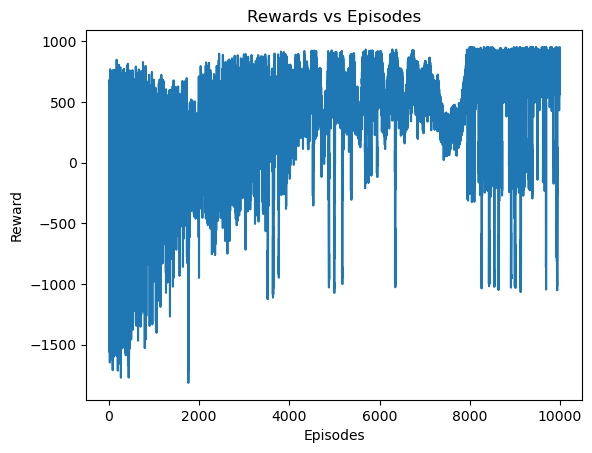

In [60]:
plt.plot(total_reward_lists)
plt.title('Rewards vs Episodes')
plt.xlabel('Episodes')
plt.ylabel('Reward')

In [65]:
dqn.eval()
x=env.get_state()
print(x)
A=31
x['acBECwminLink1']=2
x['mldThptTotal']=A*3
print(x)
print(convert(dton(x)))
z=env.get_valid_moves()
print(z)
y=dqn(convert(dton(x)),True,convert(env.get_valid_moves()))
print(y)

{'acBECwminLink1': 0, 'acBECwStageLink1': 6, 'mldThptTotal': 93}
{'acBECwminLink1': 2, 'acBECwStageLink1': 6, 'mldThptTotal': 93}
tensor([[ 2.,  6., 93.]])
[0 1]
tensor([[    -inf, 677.1393]], grad_fn=<AddBackward0>)
